In [ ]:
pip install tensorflow_ranking

In [ ]:
import tensorflow as tf
import tensorflow_ranking as tfr
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler


In [ ]:
# f23 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-23-usable.csv")
f22 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-22-usable.csv")
f21 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-21-usable.csv")
f20 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-20-usable.csv")
f19 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-19-usable.csv")
f18 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-18-usable.csv")
f17 = pd.read_csv("/content/drive/MyDrive/FIFA/FUTBIN Usable/futbin-17-usable.csv")

In [ ]:
## Mode Imputation (works better with categorical data)
for i,j in zip([f22,f21,f20,f19,f18,f17],[22,21,20,19,18,17]):
    for k in i.columns:
        exec(f"f{j}[k] = i[k].fillna(i[k].mode().iloc[0])")

In [ ]:
## Making Sure All Numeric Values are Integers (because there are no float values in the dataset)
for i,j in zip([f22,f21,f20,f19,f18,f17],[22,21,20,19,18,17]):
    for k in i.columns:
        if i[k].dtype == np.float64:
            exec(f"f{j}[k] = f{j}[k].astype(np.int64)")

In [ ]:
## Removing Values Where Popularity == 0, Standardizing Popularity Values by Year to Scale of f22
# s.fit(f22["pop"].to_numpy().reshape(-1,1)) -> We can try fitting to {largest dataset}.iloc[i.shape[0]] but for now I am just going to normalize them to themselves
# print(f22["pop"].to_numpy().reshape(-1,1))
for i,j in zip([f22, f21, f20, f19, f18, f17], ["f22", "f21", "f20", "f19", "f18", "f17"]):
    s = MinMaxScaler((0,100))
    exec(f"{j} = {j}.query('pop != 0').reset_index(drop=True)")
    exec(f"{j}['pop'] = s.fit_transform({j}['pop'].to_numpy().reshape(-1,1)).reshape(-1,)")

## Data Visualization

In [ ]:
from matplotlib.backend_bases import register_backend
LW = f22[f22.position == "LW"]
ST = f22[f22.position == "ST"]
RW = f22[f22.position == "RW"]

LM = f22[f22.position == "LM"]
CAM = f22[f22.position == "CAM"]
CM = f22[f22.position == "CM"]
CDM = f22[f22.position == "CDM"]
RM = f22[f22.position == "RM"]

LB = f22[f22.position == "LB"]
CB = f22[f22.position == "CB"]
RB = f22[f22.position == "RB"]

for i in [f21,f20,f19,f18,f17]:
    LW = pd.concat((LW, i[i.position == "LW"]), ignore_index=True)
    ST = pd.concat((ST, i[i.position == "ST"]), ignore_index=True)
    RW = pd.concat((RW, i[i.position == "RW"]), ignore_index=True)
    
    LM = pd.concat((LM, i[i.position == "LM"]), ignore_index=True)
    CAM = pd.concat((CAM, i[i.position == "CAM"]), ignore_index=True)
    CM = pd.concat((CM, i[i.position == "CM"]), ignore_index=True)
    CDM = pd.concat((CDM, i[i.position == "CDM"]), ignore_index=True)
    RM = pd.concat((RM, i[i.position == "RM"]), ignore_index=True)

    LB = pd.concat((LB, i[i.position == "LB"]), ignore_index=True)
    CB = pd.concat((CB, i[i.position == "CB"]), ignore_index=True)
    RB = pd.concat((RB, i[i.position == "RB"]), ignore_index=True)


ATT = pd.concat((LW, ST, RW), ignore_index=True)
MID = pd.concat((LM, CAM, CM, CDM, RM), ignore_index=True)
DEF = pd.concat((LB, CB, RB), ignore_index=True)
TOT = pd.concat((ATT, MID, DEF), ignore_index=True)

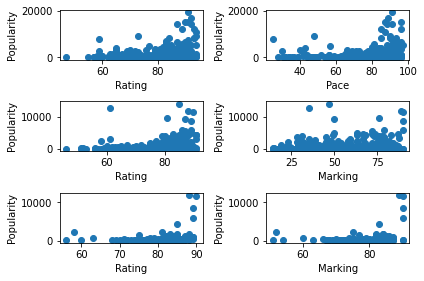

In [ ]:
for i,j in zip([ATT, MID, DEF, TOT, LW, ST, RW, LM, CAM, CM, CDM, RM, LB, CB, RB], ["ATT", "MID", "DEF", "TOT", "LW", "ST", "RW", "LM", "CAM", "CM", "CDM", "RM", "LB", "CB", "RB"]):
    keep = []
    for k in range(i.shape[0]):
        if i["pop"].iloc[k] > 100:
            keep.append(k)
    exec(f"{j} = {j}.iloc[{keep}].reset_index(drop=True)")
            
fig,axes = plt.subplots(3,2)

axes[0,0].scatter(ATT["rat"], ATT["pop"])
axes[0,0].set_xlabel("Rating")
axes[0,0].set_ylabel("Popularity")
axes[0,1].scatter(ATT["pace"], ATT["pop"])
axes[0,1].set_xlabel("Pace")
axes[0,1].set_ylabel("Popularity")

axes[1,0].scatter(MID["rat"], MID["pop"])
axes[1,0].set_xlabel("Rating")
axes[1,0].set_ylabel("Popularity")
axes[1,1].scatter(MID["marking"], MID["pop"])
axes[1,1].set_xlabel("Marking")
axes[1,1].set_ylabel("Popularity")

axes[2,0].scatter(CDM["rat"], CDM["pop"])
axes[2,0].set_xlabel("Rating")
axes[2,0].set_ylabel("Popularity")
axes[2,1].scatter(CDM["marking"], CDM["pop"])
axes[2,1].set_xlabel("Marking")
axes[2,1].set_ylabel("Popularity")

fig.tight_layout()
## Of note:: There isn't really good correlations between Overall Rating and Popularity.

In [ ]:
df = TOT[["Skills", "Weak Foot", "pop"]]
df = s.fit_transform(df)

from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(df[:,0], df[:,1], df[:,1], cmap=cm.coolwarm)
ax.invert_yaxis()

## Note a High Correlation Between Weak Foot and Popularity

In [ ]:
data = tf.constant(f21.Nation)

## Ranking Modeling

In [ ]:
tr = pd.concat((f17,f18,f19,f20,f21))
# tr["pop"] = tr["pop"].astype(np.int64)
target = tr["pop"].astype(np.float64)
X_tr = tr.drop(columns=["pop"],axis=1)

num_data = X_tr.select_dtypes(include=np.int64).drop(columns=["League ID", "Club ID"]).to_numpy(dtype=np.float64)
nat_data = X_tr["Nation"].to_numpy()
pos_data = X_tr["position"].to_numpy()
club_data = X_tr["Club ID"].astype(np.float64).to_numpy(dtype=np.float64)
league_data = X_tr["League ID"].astype(np.float64).to_numpy(dtype=np.float64)

# with tpu_strategy.scope():
num_in = tf.keras.layers.Input(
    shape=(57,),
    name="num",
    dtype=tf.int64
    )
nat_in = tf.keras.layers.Input(
    shape=(1,),
    name="nat",
    dtype=tf.string
    )
pos_in = tf.keras.layers.Input(
    shape=(1,),
    name="pos",
    dtype=tf.string
    )
club_in = tf.keras.layers.Input(
    shape=(1,),
    name="club",
    dtype=tf.int64
)
league_in = tf.keras.layers.Input(
    shape=(1,),
    name="league",
    dtype=tf.int64
)

pos_vocab = ["LW", "ST", "RW", "LM", "CAM", "CM", "RM", "LB", "CB", "RB"]

nat_lookup = tf.keras.layers.StringLookup(output_mode="count")
nat_lookup.adapt(nat_data)
pos_lookup = tf.keras.layers.StringLookup(vocabulary=pos_vocab, output_mode="count")
club_lookup = tf.keras.layers.IntegerLookup()
club_lookup.adapt(club_data)
league_lookup = tf.keras.layers.IntegerLookup()
league_lookup.adapt(league_data)

nat_em = tf.keras.layers.Embedding(input_dim=nat_lookup.vocabulary_size(), output_dim=3, mask_zero=True)
pos_em = tf.keras.layers.Embedding(input_dim=pos_lookup.vocabulary_size(), output_dim=3, mask_zero=True)
club_em = tf.keras.layers.Embedding(input_dim=club_lookup.vocabulary_size(), output_dim=3, mask_zero=True)
league_em = tf.keras.layers.Embedding(input_dim=league_lookup.vocabulary_size(), output_dim=3, mask_zero=True)

nat_lookup = nat_lookup(nat_in)
nat_em = nat_em(nat_lookup)

pos_lookup = pos_lookup(pos_in)
pos_em = pos_em(pos_lookup)

club_lookup = club_lookup(club_in)
club_em = club_em(club_lookup)

league_lookup = league_lookup(league_in)
league_em = league_em(league_lookup)

nat_norm = tf.keras.layers.BatchNormalization()(nat_em)
pos_norm = tf.keras.layers.BatchNormalization()(pos_em)
club_norm = tf.keras.layers.BatchNormalization()(club_em)
league_norm = tf.keras.layers.BatchNormalization()(league_em)
num_norm = tf.keras.layers.BatchNormalization()(num_in)

nat_reshape = tf.keras.layers.Reshape((-1,))(nat_norm)
pos_reshape = tf.keras.layers.Reshape((-1,))(pos_norm)
club_reshape = tf.keras.layers.Reshape((-1,))(club_norm)
league_reshape = tf.keras.layers.Reshape((-1,))(league_norm)
num_reshape = tf.keras.layers.Reshape((-1, ))(num_norm)

joined = tf.keras.layers.concatenate([nat_reshape, pos_reshape, club_reshape, league_reshape, num_reshape], axis=1)

rank0 = tf.keras.layers.Dense(8, name="rank0", activation=tf.nn.relu)(joined)
rank1 = tf.keras.layers.Dense(128, name="rank1", activation=tf.nn.relu)(rank0)
# rank2 = tf.keras.layers.Dense(256, name="rank2", activation=tf.nn.relu)(rank1)
# rank3 = tf.keras.layers.Dense(512, name="rank3", activation=tf.nn.relu)(rank2)
rank = tf.keras.layers.Dense(1, name="final", activation=tf.nn.relu)(rank1)

model = tf.keras.Model(
    inputs = [num_in, nat_in, pos_in, club_in, league_in],
    outputs=[rank]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfr.keras.losses.SoftmaxLoss(),
    metrics=tfr.keras.metrics.MRRMetric())

batch_size = 70
train_steps = X_tr.shape[0] // batch_size

history = model.fit(
    x={
    "num":num_data,
    "nat":nat_data,
    "pos":pos_data,
    "club":club_data,
    "league":league_data
    }, 
    steps_per_epoch=train_steps,
    y=target,
    epochs=10)


Epoch 1/10
743/743 [==============================] - 11s 10ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 2/10
743/743 [==============================] - 5s 7ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 3/10
743/743 [==============================] - 5s 7ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9998
Epoch 4/10
743/743 [==============================] - 5s 7ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 5/10
743/743 [==============================] - 5s 7ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 6/10
743/743 [==============================] - 8s 10ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 7/10
743/743 [==============================] - 8s 10ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9998
Epoch 8/10
743/743 [==============================] - 6s 8ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9998
Epoch 9/10
743/743 [==============================] - 5s 7ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997
Epoch 10/10
642/743 [===

743/743 [==============================] - 5s 6ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9997


In [ ]:
num_data = f22.select_dtypes(include=np.int64).drop(columns=["League ID", "Club ID"]).to_numpy(dtype=np.float64)
nat_data = f22["Nation"].to_numpy()
pos_data = f22["position"].to_numpy()
club_data = f22["Club ID"].astype(np.float64).to_numpy(dtype=np.float64)
league_data = f22["League ID"].astype(np.float64).to_numpy(dtype=np.float64)
pred = model.predict(x={
    "num":num_data,
    "nat":nat_data,
    "pos":pos_data,
    "club":club_data,
    "league":league_data
    })

455/455 [==============================] - 1s 2ms/step


In [ ]:
df = pd.DataFrame(pred, columns=["pop"])
df = df.sort_values("pop", ascending=True).query("pop != 0")
for i in df[:5].index:
    print(f22[["Name", "rat"]].iloc[i], pred[i])

Name    Cristian Battocchio
rat                      69
Name: 4924, dtype: object [8.015893e-06]
Name    Ovie Ejaria
rat              73
Name: 2724, dtype: object [8.416362e-06]
Name    Bouna Sarr
rat             75
Name: 1588, dtype: object [1.3649464e-05]
Name    Christopher Buchtmann
rat                        66
Name: 7586, dtype: object [3.0755065e-05]
Name    Marcel Ruiz
rat              72
Name: 3384, dtype: object [3.119372e-05]


In [ ]:
tf.keras.backend.clear_session()
del model

In [ ]:
model.evaluate(x={
    "num":num_data,
    "nat":nat_data,
    "pos":pos_data,
    "club":club_data,
    "league":league_data
    }, y = f22["pop"])

455/455 [==============================] - 3s 4ms/step - loss: 0.0000e+00 - mrr_metric_3: 0.9999


[0.0, 0.999931275844574]

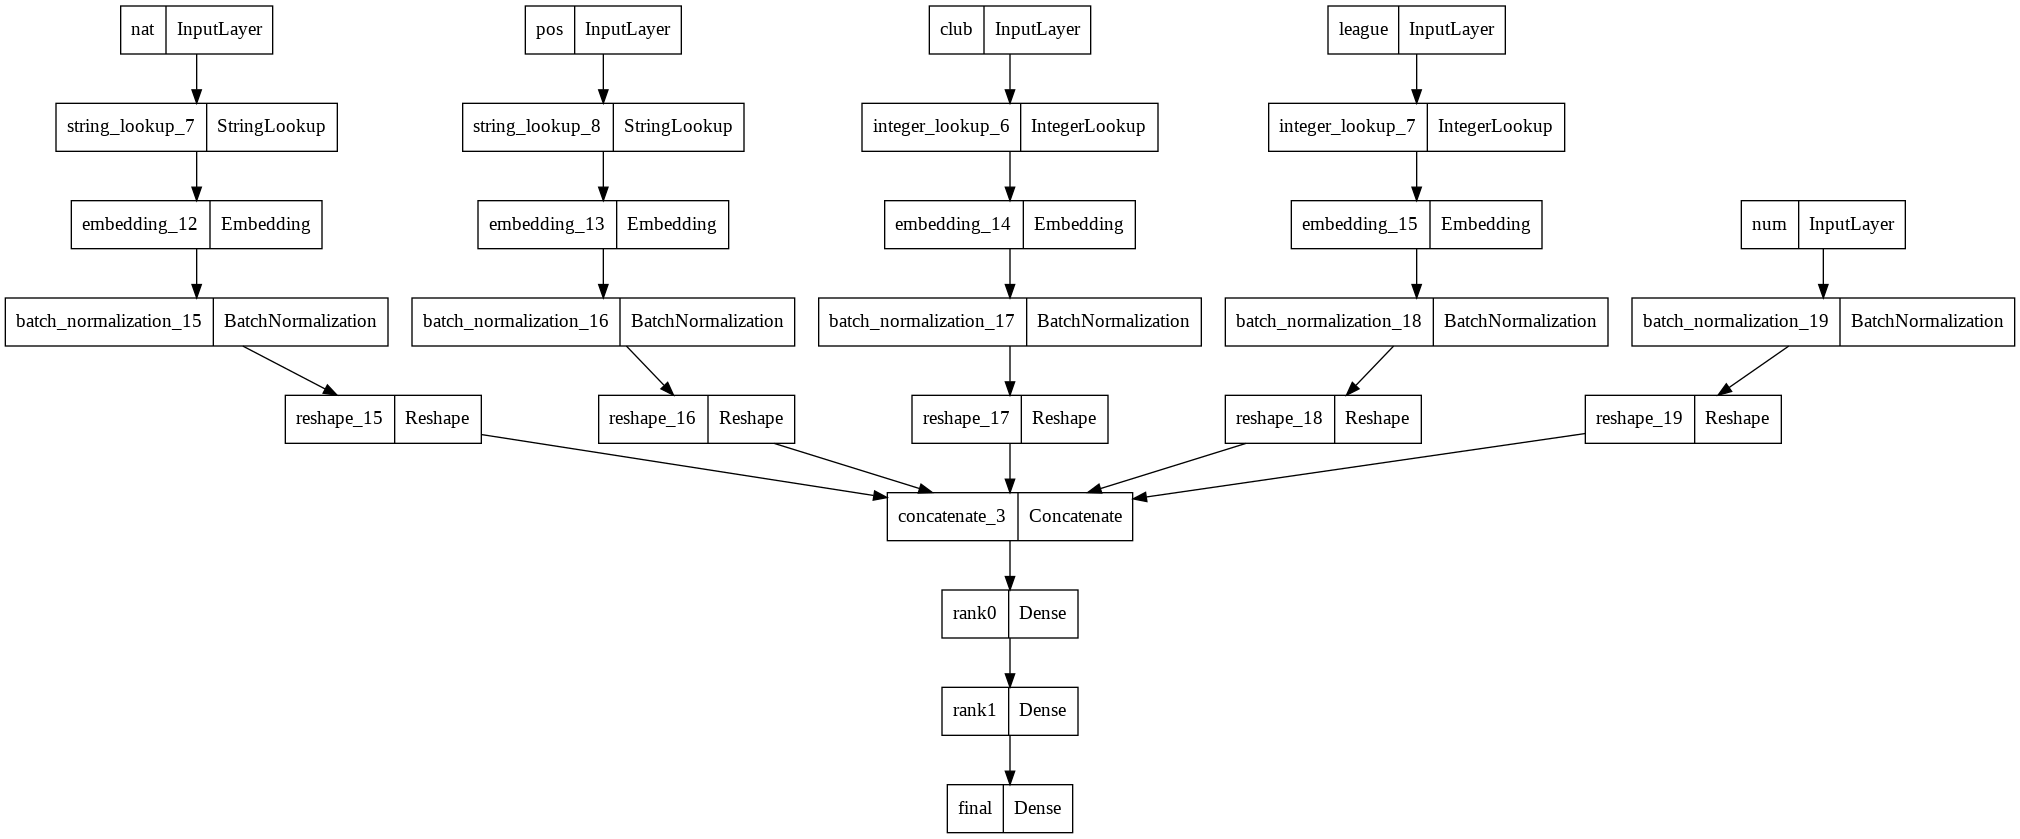

In [ ]:
tf.keras.utils.plot_model(model)

Epoch 1/10
133/133 [==============================] - 4s 3ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 2/10
133/133 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 3/10
133/133 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 4/10
133/133 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 5/10
133/133 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 6/10
133/133 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 7/10
133/133 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 8/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 9/10
133/133 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999
Epoch 10/10
105/133 [=======

133/133 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - mrr_metric_1: 0.9999


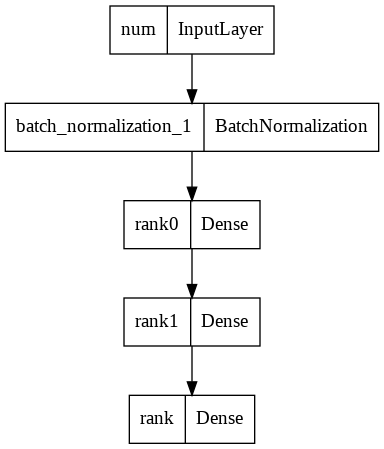

In [ ]:
tr = pd.concat((f17,f18,f19,f20,f21)).query("position == 'ST'")
# tr["pop"] = tr["pop"].astype(np.int64)
target = tr["pop"].astype(np.float64)
X_tr = tr.drop(columns=["pop"],axis=1)

num_data = X_tr.select_dtypes(include=np.int64).drop(columns=["League ID", "Club ID"]).to_numpy(dtype=np.float64)

num_in = tf.keras.layers.Input(
    shape=(57,),
    name="num",
    dtype=tf.int64
    )
num_norm = tf.keras.layers.BatchNormalization()(num_in)
rank0 = tf.keras.layers.Dense(8, name="rank0", activation=tf.nn.relu)(num_norm)
rank1 = tf.keras.layers.Dense(128, name="rank1", activation=tf.nn.relu)(rank0)
rank = tf.keras.layers.Dense(1, name="rank", activation=tf.nn.relu)(rank1)

model = tf.keras.Model(
    inputs = [num_in],
    outputs=[rank]
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tfr.keras.losses.SoftmaxLoss(),
    metrics=tfr.keras.metrics.MRRMetric())

batch_size = 70
train_steps = X_tr.shape[0] // batch_size

history = model.fit(
    x=num_data,
    steps_per_epoch=train_steps,
    y=target,
    epochs=10)
tf.keras.utils.plot_model(model)

In [ ]:
num_data = f22.select_dtypes(include=np.int64).drop(columns=["League ID", "Club ID"]).to_numpy(dtype=np.float64)
pred = model.predict(x=num_data)
df = pd.DataFrame(pred, columns=["pop"])
df = df.sort_values("pop", ascending=False).query("pop != 0")
for i in df[:5].index:
    print(f22[["Name", "rat"]].iloc[i], pred[i])

455/455 [==============================] - 1s 3ms/step
Name    Radamel Falcao García Zarate
rat                               78
Name: 831, dtype: object [2.2194796]
Name    Zlatan Ibrahimović
rat                     84
Name: 101, dtype: object [2.0748007]
Name    Bas Dost
rat           77
Name: 1115, dtype: object [1.9215517]
Name    Bas Dost
rat           77
Name: 899, dtype: object [1.9215517]
Name    Serge Aurier
rat               80
Name: 488, dtype: object [1.8276758]
